# Hyperparams

In [1]:
#pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [2]:
import time
import os
start_time = time.time()
import torch
from torch.utils.tensorboard import SummaryWriter
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mask_ratio =        0.75

########### PATHS ############
if os.name == 'posix': #mac
    fine_tune_path_imgs = '/Users/alexandermittet/Library/CloudStorage/SeaDrive-almi(seafile.erda.dk) (14.03.2024 13.32)/My Libraries/BA_data/img'
    pretrain_path_imgs = '/Users/alexandermittet/Library/CloudStorage/SeaDrive-almi(seafile.erda.dk) (14.03.2024 13.32)/My Libraries/BA_data/frames/class_0'
    pretrain_path =     '/Users/alexandermittet/Library/CloudStorage/SeaDrive-almi(seafile.erda.dk) (14.03.2024 13.32)/My Libraries/BA_data/frames'
    val_path_imgs =     "/Users/alexandermittet/Library/CloudStorage/SeaDrive-almi(seafile.erda.dk) (14.03.2024 13.32)/My Libraries/BA_data/validation_frames/class_0"
    val_path =          "/Users/alexandermittet/Library/CloudStorage/SeaDrive-almi(seafile.erda.dk) (14.03.2024 13.32)/My Libraries/BA_data/validation_frames"
    load_prev_mae_model_path =  '/Users/alexandermittet/Library/CloudStorage/SeaDrive-almi(seafile.erda.dk) (14.03.2024 13.32)/My Libraries/BA_data/models/'#mae_checkpoint_epoch-60_7198_mask-0.5 ups 0.75.pth'
elif os.name == 'nt': #windows
    fine_tune_path_imgs = 'C:\\Users\\alx\\Downloads\\img\\img'
    pretrain_path =     r'C:\Users\alx\Downloads\BA_data\frames'
    val_path =          r'C:\Users\alx\Downloads\BA_data\val_frames'
    load_prev_mae_model_path =   f"C:\\Users\\alx\Downloads\\mdl_ckpt\\mae_m-{mask_ratio}" #MAE load
    model_used =        "last"
    load_prev_fine_model_path   = f'C:\\Users\\alx\\Downloads\\mdl_ckpt\\mes_m-0.5\\mes_{model_used}.pth'


########### HYPER PARAMETERS ############
### MODEL SIZE
emb_dims =          192#192 #skal ku duvuderes med num_heads som er 4 
                    #85M params i TIMM classifiers, så den har vi smags til at 190*4 passer med 12 layers
encoder_layers =    12#12 i timm
architecture = "vit_base_patch16_224" #tiny eller small

### Pretraining
training =          False #Pre-training MAE
num_epochs =        33
dim =               224


### Global hyper params
custom_opt =            "prodigy" #bliver også brugt til fine tuning
learn_rate =            0.001
MAE_batch_size =        32
mes_batch_size =        32
load_prev_model =       False #MAE load
mae_to_load =           'mae_last_bs512.pth'
mae_load_path = os.path.join(load_prev_mae_model_path, mae_to_load)

### Fine-tuning
three_shot =        True # 3-shot mes runs w/plots
load_fine_tuned =   False or three_shot #meS vi bliver nødt til, for at evaluere MES best.pth (og ikke last, som vi stadig ligger i memory)
fine_tuning =       False or three_shot #MES training
fine_tune_eval =    False or three_shot
num_fine_epochs =   5 #overfitter efter færre faktisk, men vi gemmer også best

###SSIM Score #approx x mins
plot_ssim        =       False
### Plot best and worst loss imgs
plot_bwl =          False

### T-sne feature plotting # approx 5 mins
tsne_plotting =     False
# tsne_target =       "all mes" #mes: "all mes", "mes1to3" #MAE:"validation images" "training images"
plot_single_image = False
plot_16_images =    False or load_prev_model #might aswell så vi kan se hvor god vi loader

### PCA #approx 4 mins
plot_pca   =        False

### Misc
get_num_params =    False
break_after_num_steps = -1
use_class4 =        False

run_name =          f"decontam-data_opt_{custom_opt}_max-e-{num_epochs}_m-{mask_ratio}_fine-e-{num_fine_epochs}_MAE-mes-bs-{MAE_batch_size}-{mes_batch_size}" #hyperparam string

## Dataset

In [3]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from torchvision import transforms
#import torch.optim as optim #bruger prodigy
from torch.utils.data import DataLoader
import numpy as np
from prodigyopt import Prodigy
from torch.optim import AdamW
import lightning as L
# import wandb

from einops import repeat, rearrange
from einops.layers.torch import Rearrange

from timm.models.layers import trunc_normal_
from timm.models.vision_transformer import Block
from tqdm import tqdm

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((dim, dim)), # Resize the image
    transforms.ToTensor(), # Convert the image to a PyTorch tensor
])

#dataset = CustomFramesDataset(root_dir=frames_path, transform=transform)
dataset = ImageFolder(
        pretrain_path,
        transform=transform,
    )

val_dataset = ImageFolder(
        val_path,
        transform=transform,
    ) 

c:\Users\alx\miniconda3.2\envs\BA\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# model architecture + masking fn

In [4]:
## ViT Model + functions
class MAE_Encoder(torch.nn.Module):
    def __init__(self,
                 image_size=dim,
                 patch_size=16,
                 emb_dim=emb_dims,
                 num_layer=encoder_layers,
                 num_head=4,
                 mask_ratio=mask_ratio,
                 ) -> None:
        super().__init__()

        self.cls_token = torch.nn.Parameter(torch.zeros(1, 1, emb_dim))
        self.pos_embedding = torch.nn.Parameter(torch.zeros((image_size // patch_size) ** 2, 1, emb_dim))
        self.shuffle = PatchShuffle(mask_ratio)

        self.patchify = torch.nn.Conv2d(3, emb_dim, patch_size, patch_size)

        self.transformer = torch.nn.Sequential(*[Block(emb_dim, num_head) for _ in range(num_layer)])

        self.layer_norm = torch.nn.LayerNorm(emb_dim)

        self.init_weight()

    def init_weight(self):
        trunc_normal_(self.cls_token, std=.02)
        trunc_normal_(self.pos_embedding, std=.02)

    def forward(self, img):
        patches = self.patchify(img)
        patches = rearrange(patches, 'b c h w -> (h w) b c')
        
        # Calculate the number of patches
        num_patches = patches.shape[0]
        

        
        patches = patches + self.pos_embedding

        patches, forward_indexes, backward_indexes = self.shuffle(patches)

        patches = torch.cat([self.cls_token.expand(-1, patches.shape[1], -1), patches], dim=0)
        patches = rearrange(patches, 't b c -> b t c')
        features = self.layer_norm(self.transformer(patches))
        features = rearrange(features, 'b t c -> t b c')

        return features, backward_indexes

class MAE_Decoder(torch.nn.Module):
    def __init__(self,
                 image_size=dim,
                 patch_size=16,
                 emb_dim=192,
                 num_layer=4,
                 num_head=3,
                 ) -> None:
        super().__init__()

        self.mask_token = torch.nn.Parameter(torch.zeros(1, 1, emb_dim))
        self.pos_embedding = torch.nn.Parameter(torch.zeros((image_size // patch_size) ** 2 + 1, 1, emb_dim))

        self.transformer = torch.nn.Sequential(*[Block(emb_dim, num_head) for _ in range(num_layer)])

        self.head = torch.nn.Linear(emb_dim, 3 * patch_size ** 2)
        self.patch2img = Rearrange('(h w) b (c p1 p2) -> b c (h p1) (w p2)', p1=patch_size, p2=patch_size, h=image_size//patch_size)

        self.init_weight()

    def init_weight(self):
        trunc_normal_(self.mask_token, std=.02)
        trunc_normal_(self.pos_embedding, std=.02)

    def forward(self, features, backward_indexes):
        T = features.shape[0]
        backward_indexes = torch.cat([torch.zeros(1, backward_indexes.shape[1]).to(backward_indexes), backward_indexes + 1], dim=0)
        features = torch.cat([features, self.mask_token.expand(backward_indexes.shape[0] - features.shape[0], features.shape[1], -1)], dim=0)
        features = take_indexes(features, backward_indexes)
        features = features + self.pos_embedding

        features = rearrange(features, 't b c -> b t c')
        features = self.transformer(features)
        features = rearrange(features, 'b t c -> t b c')
        features = features[1:] # remove global feature

        patches = self.head(features)
        mask = torch.zeros_like(patches)
        mask[T-1:] = 1
        mask = take_indexes(mask, backward_indexes[1:] - 1)
        img = self.patch2img(patches)
        mask = self.patch2img(mask)

        return img, mask

class MAE_ViT(torch.nn.Module):
    def __init__(self,
                 image_size=dim,
                 patch_size=16,
                 emb_dim=emb_dims,#192,
                 encoder_layer=encoder_layers,#12,
                 encoder_head=4,
                 decoder_layer=4,
                 decoder_head=4,
                 mask_ratio=mask_ratio,
                 ) -> None:
        super().__init__()

        self.encoder = MAE_Encoder(image_size, patch_size, emb_dim, encoder_layer, encoder_head, mask_ratio)
        self.decoder = MAE_Decoder(image_size, patch_size, emb_dim, decoder_layer, decoder_head)

    def forward(self, img):
        features, backward_indexes = self.encoder(img)
        predicted_img, mask = self.decoder(features,  backward_indexes)
        return predicted_img, mask

class ViT_Classifier(torch.nn.Module):
    def __init__(self, encoder : MAE_Encoder, num_classes=4) -> None:
        super().__init__()
        self.cls_token = encoder.cls_token
        self.pos_embedding = encoder.pos_embedding
        self.patchify = encoder.patchify
        self.transformer = encoder.transformer
        self.layer_norm = encoder.layer_norm
        self.head = torch.nn.Linear(self.pos_embedding.shape[-1], num_classes)

    def forward(self, img):
        patches = self.patchify(img)
        patches = rearrange(patches, 'b c h w -> (h w) b c')
        patches = patches + self.pos_embedding
        patches = torch.cat([self.cls_token.expand(-1, patches.shape[1], -1), patches], dim=0)
        patches = rearrange(patches, 't b c -> b t c')
        features = self.layer_norm(self.transformer(patches))
        features = rearrange(features, 'b t c -> t b c')
        logits = self.head(features[0])
        return logits
    

class PatchShuffle(torch.nn.Module):
    def __init__(self, ratio) -> None:
        super().__init__()
        self.ratio = ratio

    def forward(self, patches : torch.Tensor):
        T, B, C = patches.shape
        remain_T = int(T * (1 - self.ratio))

        indexes = [random_indexes(T) for _ in range(B)]
        forward_indexes = torch.as_tensor(np.stack([i[0] for i in indexes], axis=-1), dtype=torch.long).to(patches.device)
        backward_indexes = torch.as_tensor(np.stack([i[1] for i in indexes], axis=-1), dtype=torch.long).to(patches.device)

        patches = take_indexes(patches, forward_indexes)
        patches = patches[:remain_T]

        return patches, forward_indexes, backward_indexes
    
def random_indexes(size : int):
    forward_indexes = np.arange(size)
    np.random.shuffle(forward_indexes)
    backward_indexes = np.argsort(forward_indexes)
    return forward_indexes, backward_indexes

def take_indexes(sequences, indexes):
    return torch.gather(sequences, 0, repeat(indexes, 't b -> t b c', c=sequences.shape[-1]))

def mask_image(image, mask_size):
    mask = torch.ones_like(image)
    mask[:, :mask_size, :mask_size] = 0
    return image * mask

## load MAE model if it exists

In [5]:
def load_model():
    import torch
    import os

    if os.path.exists(mae_load_path):
        # Load the checkpoint
        checkpoint = torch.load(mae_load_path)
        
        # Load the model state dict
        model = MAE_ViT().to(device)
        model.load_state_dict(checkpoint['model_state_dict'])
        
        # Load the optimizer state dict
        if custom_opt == "prodigy":
            optimizer = Prodigy(model.parameters())
        elif custom_opt == "adamW":
            optimizer = AdamW(model.parameters(), lr=learn_rate)
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
        # Load the loss
        loss = checkpoint['loss']
        
        print(f"Model loaded with loss: {loss}")
    else:
        
        print("Model checkpoint not found.")
    return model, optimizer, loss

if load_prev_model:
    model, optimizer, loss = load_model()
else:
    model = MAE_ViT().to(device)
    if custom_opt == "adamW":
        learning_rate = learn_rate # Example learning rate
        optimizer = AdamW(model.parameters(), lr=learning_rate)
    elif custom_opt == "prodigy":
        optimizer = Prodigy(model.parameters())
    #loss er custom mse loss

# Num_params in MAE model

In [6]:
if get_num_params or plot_16_images:
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total number of parameters: {total_params:,.0f}")

# Pre-Train model:

In [7]:
from torchsampler import ImbalancedDatasetSampler
dataloader = DataLoader(dataset, batch_size=MAE_batch_size, sampler=ImbalancedDatasetSampler(dataset)) #sampler=cycle_sampler
val_loader = DataLoader(val_dataset, batch_size=MAE_batch_size, sampler=ImbalancedDatasetSampler(val_dataset))
   
if training:    #Tensorboard writer
    
    import random
    from datetime import datetime
    now = datetime.now()
    # Format the datetime string to exclude the year
    formatted_datetime = now.strftime("%m-%d_%H-%M")
    # Use the formatted datetime in the path
    writer = SummaryWriter(os.path.join("logs", "mae", f"{formatted_datetime}_{run_name}"))


    best_val_loss = float('inf')
    step_count = 0
    for epoch in range(num_epochs):
        model.train()
        losses = []
        pbar = tqdm(iter(dataloader))
        for img, label in pbar:
            step_count += 1
            img = img.to(device)
            predicted_img, mask = model(img)
            loss = (
                    torch.mean((predicted_img - img) ** 2 * mask) / mask_ratio
                )
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            losses.append(loss.item())

            pbar.set_postfix({'step loss': loss.item()}, refresh=False)
            writer.add_scalar("mae/step_train_loss", loss.item(), global_step=step_count)
            # wandb.log({"Train Loss step": loss})

            if break_after_num_steps > 0: #set to -1 to disable early breaking
                if step_count >= break_after_num_steps: #Save and quit
                    # torch.save({
                    #             'model_state_dict': model.state_dict(),
                    #             'optimizer_state_dict': optimizer.state_dict(),
                    #             'loss': loss.item(),
                    #             }, './models/mae_checkpoint_break.pth')
                    break
        
        #For every epoch:
        avg_loss = sum(losses) / len(losses)
        writer.add_scalar("mae/epoch_train_loss", avg_loss, global_step=step_count)
        print(f"####TRAIN#### epoch {epoch}/{num_epochs}, avg train loss: {avg_loss:.4f}")
        # wandb.log({"Train Loss epoch avg": avg_loss})

        """ visualize the first 16 predicted images on val dataset"""
        model.eval()
        val_losses = []
        val_bar = tqdm(iter(val_loader))
        with torch.no_grad():
            for img, label in val_bar:
                img = img.to(device)
                predicted_img, mask = model(img)
                val_loss = (
                        torch.mean((predicted_img - img) ** 2 * mask) / mask_ratio
                    )
                val_losses.append(val_loss.item())
                #break #vi vil gerne køre alt validatio igennem
            
            avg_val_loss = torch.mean(torch.tensor(val_losses))
            writer.add_scalar("mae/epoch_val_loss", avg_val_loss.item(), global_step=step_count)

            

        ### Saving
        if val_loss < best_val_loss:
            improved = True
            # Update the best loss
            best_val_loss = val_loss
            
            # Construct the filename with the current loss included
            filename = f"mae_best.pth"
        else:
            improved = False
            filename = "mae_last.pth"
        # Construct the full path using os.path.join
        base_path = f"C:\\Users\\alx\\Downloads\\mdl_ckpt\\mae_m-{mask_ratio}"
        full_path = os.path.join(base_path, filename)
        shortened_path = os.path.join(f"mdl_ckpt\\mae_m-{mask_ratio}", filename)
        
        # Save the model
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item(),
        }, full_path)
        if improved:
            print(f"###IMPROVED VAL#### Save w/avg loss {avg_loss:.4f} at {shortened_path}")
        
        improved = False


# Eval 16 random imgs

In [8]:
# import matplotlib.pyplot as plt
# import random
# from torchmetrics.image import StructuralSimilarityIndexMeasure
# def plot_16_images_():
    
#     num_samples = 16
#     indices = random.sample(range(len(val_dataset)), num_samples)
#     val_samples = [val_dataset[i][0] for i in indices]
#     val_img = torch.stack(val_samples)
#     #val_img = torch.stack([val_dataset[i][0] for i in range(21)])
    

#     val_img = val_img.to(device)
#     predicted_val_img, mask = model(val_img)
#     predicted_val_img = predicted_val_img * mask + val_img * (1 - mask)

#     img = torch.cat([val_img * (1 - mask), predicted_val_img, val_img], dim=0)
#     img = rearrange(img, "(v h1 w1) c h w -> (h1 h) (w1 v w) c", w1=2, v=3)
#     img_np = img.cpu().detach().numpy()
#     # min_val, max_val = np.min(img_np), np.max(img_np)
#     # range_val = max_val - min_val

#     # Normalize the data
#     # normalized_img_np = (img_np - min_val) / range_val

#     plt.figure(figsize=(6, 8))
#     plt.axis('off')
#     plt.title(f'MAE: 16 random val images \n MAE pretrained for: {num_epochs}eps, masking: {mask_ratio} \n MAE model has {total_params:,.0f} num params')
#     # plt.imshow(normalized_img_np)
#     plt.imshow(img_np) #imgs look grey when normalized
#     plt.tight_layout()
#     plt.savefig(f"plots/mae_image_16x_m-{mask_ratio}_params-{total_params:,.0f}.png")
#     plt.show()
# if plot_16_images:
#     plot_16_images_()

# Worst/best images (loss)

In [9]:
if plot_bwl:
    import torch
    import numpy as np
    from torch.utils.data import DataLoader
    from tqdm import tqdm

    # Assuming 'model' is your trained model and 'val_dataset' is your validation dataset
    model.eval() # Set the model to evaluation mode

    losses = []
    indices = []
    wbl_loader = DataLoader(val_dataset, batch_size=1)
    wbl_bar = tqdm(iter(wbl_loader))

    with torch.no_grad(): # Disable gradient calculation to save memory
        for i, (img, label) in enumerate(wbl_bar):
            img = img.to(device) # maybe its faster to use cpu for single image losses?
            predicted_img, mask = model(img) # Pass the image through the model
            loss = (torch.mean((predicted_img - img) ** 2 * mask) / mask_ratio)
            losses.append(loss.item()) # Store the loss
            indices.append(i) # Store the index of the image in the dataset

    # Sort the losses and select the top 10 and bottom 10
    sorted_indices = np.argsort(losses)
    top_10_indices = sorted_indices[-10:]
    bottom_10_indices = sorted_indices[:10]

    # Now, you can index into the dataset to get the images
    top_10_images = [val_dataset[i][0] for i in top_10_indices]
    bottom_10_images = [val_dataset[i][0] for i in bottom_10_indices]

In [10]:
if plot_bwl:
    x, y = 10, 5.5
    # Plotting the top 10 images with their losses
    plt.figure(figsize=(x, y))
    for i, img in enumerate(top_10_images):
        plt.subplot(2, 5, i+1)
        plt.imshow(img.permute(1, 2, 0).cpu().numpy(), cmap='gray')
        plt.title(f"Loss: {losses[top_10_indices[i]]:.4f}")
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle(f"10 highest loss images", fontsize=16)
    plt.savefig(f"plots/worst-best/mae_10_bwl_highest.png")

    # Plotting the bottom 10 images with their losses

    plt.figure(figsize=(x, y))
    for i, img in enumerate(bottom_10_images):
        plt.subplot(2, 5, i+1)
        plt.imshow(img.permute(1, 2, 0).cpu().numpy(), cmap='gray')
        plt.title(f"Loss: {losses[bottom_10_indices[i]]:.4f}")
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle(f"10 lowest loss images", fontsize=16)
    plt.savefig(f"plots/worst-best/mae_10_bwl_lowest.png")
    plt.show()

# SSIM

## Quant ssim scatterplot

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchmetrics.image import StructuralSimilarityIndexMeasure
import random

if plot_ssim:
    def plot_ssim_scores(num_samples):
        # Initialize SSIM metric with specified parameters
        ssim = StructuralSimilarityIndexMeasure(
            gaussian_kernel=True,
            sigma=1.5,
            kernel_size=11,
            reduction='none', # Get individual scores for each image
            data_range=1.0, # Assuming images are normalized between 0 and 1
            k1=0.01,
            k2=0.03,
            return_full_image=False,
            return_contrast_sensitivity=False
        ).to(device)
        
        # Sample validation images
        indices = random.sample(range(len(val_dataset)), num_samples)
        val_samples = [val_dataset[i][0] for i in indices]
        val_img = torch.stack(val_samples)
        
        # Move images to the device
        val_img = val_img.to(device)
        
        # Generate predictions
        predicted_val_img, mask = model(val_img)
        predicted_val_img = predicted_val_img * mask + val_img * (1 - mask)
        
        # Calculate SSIM scores for each image
        ssim_scores = []
        for original, predicted in zip(val_img, predicted_val_img):
            score = ssim(predicted.unsqueeze(0), original.unsqueeze(0))
            ssim_scores.append(score.item())
        
        # Convert list of scores to a NumPy array for plotting
        ssim_scores_np = np.array(ssim_scores)
        mean_sc = np.mean(ssim_scores_np)
        # Plot SSIM scores
        plt.figure(figsize=(10, 5))
        plt.plot(ssim_scores_np, marker='o', linestyle='')
        plt.title(f'SSIM Scores for Validation Images (Mean = {mean_sc})')
        plt.ylim(0, 1)
        plt.xlabel('Image Index')
        plt.ylabel('SSIM Score')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"plots/mae_ssim_scores_val.png")
        plt.show()
        
        return ssim_scores_np

if plot_ssim:
    scores = plot_ssim_scores(num_samples=1024)

In [12]:
# del val_img, predicted_val_img, mask, ssim_scores, ssim_scores_np
# #free up leaky memory
# plt.close("all")  # Close all figures

## Quali random ssim w img

In [13]:
import matplotlib.pyplot as plt
import torch
from torchmetrics.image import StructuralSimilarityIndexMeasure
from einops import rearrange

import matplotlib.pyplot as plt
import torch
from torchmetrics.image import StructuralSimilarityIndexMeasure
from einops import rearrange

def plot_single_image_ssim(index=None):
    # Select a single image from the dataset
    #pick a random index from 0 to len(val_dataset)
    if index is None:
        index = random.randint(0, len(val_dataset) - 1)
    val_img = val_dataset[index][0].unsqueeze(0).to(device)
    
    # Make a prediction
    predicted_val_img, mask = model(val_img)
    predicted_val_img = predicted_val_img * mask + val_img * (1 - mask)
    
    # Prepare the images for plotting
    # Concatenate the masked input, prediction, and ground truth
    img = torch.cat([val_img * (1 - mask), predicted_val_img, val_img], dim=0)
    # Adjust the rearrange pattern to match the new order
    img = rearrange(img, "v c h w -> (v h) w c", v=3)
    img_np = img.cpu().detach().numpy()
    # min_val, max_val = np.min(img_np), np.max(img_np)
    # range_val = max_val - min_val
    # normalized_img_np = (img_np - min_val) / range_val
    
    # Calculate SSIM score
    ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    score = ssim(val_img, predicted_val_img).item()
    
    # Plot the images
    plt.figure(figsize=(2, 6))
    plt.axis('off')
    plt.imshow(img_np) # we dont need to normalize
    
    # Add SSIM score below the plot
    plt.text(0.5, -0.1, f'SSIM: {score:.4f}', fontsize=12, ha='center', transform=plt.gca().transAxes)
    plt.tight_layout
    plt.savefig(f"plots/worst-best/single_image_SSIM_{score:.4f}.png")
    plt.show()

if plot_ssim:
    model = model.to(device)
    plot_single_image_ssim()

## Best and worst SSIM

In [14]:
if plot_ssim:
    import matplotlib.pyplot as plt

    # Assuming scores is already defined and contains your SSIM scores
    # Find the indices that would sort the scores
    sorted_indices = np.argsort(scores)

    # Select the indices of the best and worst images
    best_indices = sorted_indices[-5:] # Adjust the number as needed
    worst_indices = sorted_indices[:5] # Adjust the number as needed

    # Select the best and worst images
    best_images = [val_dataset[i][0] for i in best_indices]
    worst_images = [val_dataset[i][0] for i in worst_indices]

    # Get the SSIM scores for the best and worst images
    best_scores = [scores[i] for i in best_indices]
    worst_scores = [scores[i] for i in worst_indices]

    # Plot the best images with their SSIM scores
    plt.figure(figsize=(8, 2))
    for i, (img, score) in enumerate(zip(best_images, best_scores)):
        plt.subplot(1, len(best_images), i+1)
        plt.imshow(img.permute(1, 2, 0).cpu().numpy()) # Adjust the permute order based on your image format
        plt.title(f'SSIM: {score:.3f}')
        plt.axis('off')
    plt.suptitle('5 Best Images by SSIM Score')
    plt.tight_layout()
    plt.savefig(f"plots/5_best_images_SSIM.png")
    plt.show()


    # Plot the worst images with their SSIM scores
    plt.figure(figsize=(8, 2))
    for i, (img, score) in enumerate(zip(worst_images, worst_scores)):
        plt.subplot(1, len(worst_images), i+1)
        plt.imshow(img.permute(1, 2, 0).cpu().numpy()) # Adjust the permute order based on your image format
        plt.title(f'SSIM: {score:.3f}')
        plt.axis('off')
    plt.suptitle('5 Worst Images by SSIM Score')
    plt.tight_layout()
    plt.savefig(f"plots/5_worst_images_SSIM.png")
    plt.show()

# T-SNE feature embeddings (clustering our latent space)

### Just tsne plot:

In [15]:
if tsne_plotting:
    from torchvision import transforms
    from PIL import Image
    import numpy as np
    import os
    import torch
    from tqdm import tqdm 
    from sklearn.manifold import TSNE
    import pandas as pd
    import matplotlib.pyplot as plt

    def tsne_embeddings(input_paths: list, model) -> np.ndarray:
        encoder = model.encoder
        encoder.eval() # Set the model to evaluation mode
        
        transform = transforms.Compose([
            transforms.Resize((224, 224)), # Adjust size as needed
            transforms.ToTensor(),
        ])

        # Extract features
        features = []
        for path in tqdm(input_paths, desc="Processing images"): # Wrap image_paths with tqdm
            img = Image.open(path)
            img = transform(img).unsqueeze(0) # Add batch dimension
            with torch.no_grad():
                _, feature = encoder(img)
            features.append(feature.squeeze().numpy())
        # np.vstack enables parallel processing
        features = np.vstack(features)

        # Apply t-SNE
        tsne = TSNE(n_components=2, random_state=42, n_jobs=-1, verbose=1) #12 it/s ved n_jobs=None
        embeddings = tsne.fit_transform(features)
        
        return embeddings

    # if tsne_target == "training images":
    #     embedding = tsne_embeddings(pretrain_path_imgs)
    # elif tsne_target == "validation images":
    #     embedding = tsne_embeddings(val_path_imgs)
    # §if tsne_target == "all mes":
    if True:
        df = pd.read_csv('img_labels_ALL.csv')
        image_paths = [os.path.join(fine_tune_path_imgs, img_name) for img_name in df['img']]
        #####TAKES TIME#######
        embeddings = tsne_embeddings(image_paths, model)
    else:
        print("Invalid target for t-SNE plotting")


In [16]:
#PLOT
if tsne_plotting:
    import seaborn as sns
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=embeddings[:, 0], y=embeddings[:, 1], hue=df['score'], palette='viridis')
    plt.title('MES images t-SNE embeddings from MAE')
    plt.legend(title='MES-score', title_fontsize='13')
    plt.savefig(f"plots/tsne/mes/t-sne_all.png")

### tsne with images on top

In [17]:
def plot_tsne(input_path, which_type):
    import os
    import matplotlib.pyplot as plt
    from matplotlib.offsetbox import OffsetImage, AnnotationBbox

    def getImage(path, zoom=.025):
        return OffsetImage(plt.imread(path), zoom=zoom)

    # Specify the directory containing the images
    image_directory = input_path

    # List all files in the directory
    files = os.listdir(image_directory)

    # Filter out the image files (assuming .jpg and .png extensions)
    image_files = [os.path.join(image_directory, f) for f in files if f.endswith(('.jpg', '.png'))]

    # Create a figure and axes
    fig, ax = plt.subplots()

    # Assuming 'embedding' is defined elsewhere in your code
    for x0, y0, path in zip(embedding[:, 0], embedding[:, 1], image_files):
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)

    # Set the limits of the plot to ensure all images are visible
    # You might need to adjust these limits based on the range of your embedding coordinates
    ax.set_xlim(embedding[:, 0].min(), embedding[:, 0].max())
    ax.set_ylim(embedding[:, 1].min(), embedding[:, 1].max())
    from datetime import datetime
    now = datetime.now()
    timestamp = now.strftime("%y%m%d_%H%M")
    
    title = f" T-sne plot of feature embeddings of {which_type} images. Mask Ratio: {mask_ratio}"

    # Set the title of the plot
    ax.set_title(title)

    # Save the figure with the datetime stamp in the filename
    plt.savefig(f'./plots/tsne_time-{timestamp}_mask-{mask_ratio}_type-{which_type}.png')
    plt.show()

if tsne_plotting:
    if tsne_target == "training images":
        plot_tsne(pretrain_path_imgs, 'training')
    elif tsne_target == "validation images":
        plot_tsne(val_path_imgs,'validation')

# PCA feature embeddings

In [18]:

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from PIL import Image
import torch
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np

def pca_embeddings(input_paths: list, model) -> np.ndarray:
    encoder = model.encoder
    encoder = encoder.to(device)
    encoder.eval() # Set the model to evaluation mode
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)), # Adjust size as needed
        transforms.ToTensor(),
    ])

    # Extract features
    features = []
    for path in tqdm(input_paths, desc="Processing images"): # Wrap image_paths with tqdm
        img = Image.open(path)
        img = transform(img).unsqueeze(0) # Add batch dimension
        img = img.to(device)
        with torch.no_grad():
            feature, backwards_index = encoder(img) #MAE ENC: return features, backward_indexes
        features.append(feature.squeeze().cpu().numpy())
    # np.vstack enables parallel processing
    features = np.vstack(features)

    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(features)

    pca = PCA().fit(scaled_features)    
    explained_variance = pca.explained_variance_ratio_

    cumulative_explained_variance = np.cumsum(explained_variance)


    return explained_variance, cumulative_explained_variance

if plot_pca:
    import pandas as pd
    df = pd.read_csv('img_labels_ALL.csv')
    image_paths = [os.path.join(fine_tune_path_imgs, img_name) for img_name in df['img']]
    #####TAKES TIME#######
    explained_variance, cumulative_explained_variance = pca_embeddings(image_paths, model)

In [19]:
if plot_pca:
    num_components_for_80_variance = np.argmax(cumulative_explained_variance >= 0.80) + 1
    print(f"Number of components needed for 80% variance: {num_components_for_80_variance}")

    num_components_for_95_variance = np.argmax(cumulative_explained_variance >= 0.95) + 1
    print(f"Number of components needed for 95% variance: {num_components_for_95_variance}")

In [20]:
if plot_pca:
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, len(explained_variance) + 1), cumulative_explained_variance, marker='.', linestyle='--')
    # plt.axvline(x=138, color='red', linestyle='--')
    # plt.axvline(x=179, color='red', linestyle='--')
    plt.axhline(y=0.8, color='red', linestyle='--')
    plt.axhline(y=0.95, color='red', linestyle='--')
    plt.xlim(0, emb_dims)
    plt.plot([num_components_for_80_variance, num_components_for_95_variance], [0.8, 0.95], 'ro')
    plt.xlabel('Number of Components (Embedded Dimensions)')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA - Explained Variance by Number of Embedded Dimensions')
    plt.legend([
        'Cumulative Explained Variance',
        f'80% Explained Variance ({num_components_for_80_variance} components)',
        f'95% Explained Variance ({num_components_for_95_variance} components)'
    ], loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"plots/pca_num_emb-dims_m-{mask_ratio}.png")
    plt.show()

# Fine tune model MES score 1x 

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torchsampler import ImbalancedDatasetSampler
import timm
# encoder = model.encoder
# classifier = ViT_Classifier(encoder, num_classes=4)
# classifier = timm.create_model(
#             architecture, pretrained=True, num_classes=4
#         )  # Get model architecture
# classifier.to(device)
# criterion = torch.nn.CrossEntropyLoss()

# #initialize new optimizers that arent biased from MAE training
# if custom_opt == "prodigy":
#     optimizer = Prodigy(classifier.parameters())
# elif custom_opt == "adamW":
#     optimizer = AdamW(classifier.parameters(), lr=learn_rate)

class CustomDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 0]
        img_path = f'{fine_tune_path_imgs}/{img_name}' ##### MAN KAN ÆNDRE PATH HER ift /class_0
        image = Image.open(img_path).convert('RGB')
        label = torch.tensor(self.df.iloc[idx, 2], dtype=torch.long)
        if self.transform:
            image = self.transform(image)
        return image, label
    def get_labels(self):
        label = torch.tensor(self.df.iloc[:, 2].tolist(), dtype=torch.long)
        return label
    
def init_dataloaders():
        #DATA LABELS
    df = pd.read_csv('img_labels_ALL.csv')

    # Remove class 4 (images lablelled as bad examples)
    if use_class4 == False:
        df = df[df['score'] != 4.0]
    #df.head() #Sanity check

    # Only use images that exist in the directory
    image_folder = fine_tune_path_imgs
    image_exists = df['img'].apply(lambda x: os.path.isfile(os.path.join(image_folder, x))) 
    filtered_df = df[image_exists]
    print(f"Original DataFrame size: {len(df)}, Filtered DataFrame size: {len(filtered_df)}") #Sanity check
    df = filtered_df

    # Stratify/balance classes across splits
    labels = df['score'].values
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=labels)
    train_labels = train_df['score'].values
    train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_labels)

    # Create data loaders for training and validation sets
    test_data = CustomDataset(test_df, transform)
    train_data = CustomDataset(train_df, transform)
    val_data = CustomDataset(val_df, transform)

    #More workers for GPU/lambda
    if torch.cuda.is_available():
        num_workers_local = 0
        test_loader = DataLoader(test_data, batch_size=mes_batch_size, num_workers=num_workers_local)
        train_loader = DataLoader(train_data, batch_size=mes_batch_size, sampler=ImbalancedDatasetSampler(train_data))#, num_workers=num_workers_local)
        val_loader = DataLoader(val_data, batch_size=mes_batch_size, num_workers=num_workers_local)
    else:
        test_loader = DataLoader(test_data, batch_size=mes_batch_size)
        train_loader = DataLoader(train_data, batch_size=mes_batch_size, sampler=ImbalancedDatasetSampler(train_data))
        val_loader = DataLoader(val_data, batch_size=mes_batch_size)
    return train_loader, val_loader, test_loader, test_data




def single_mes_run(iteration=None):
    if fine_tuning == True or three_shot:
        train_loader, val_loader, test_loader, test_data = init_dataloaders()
        classifier = timm.create_model(
            architecture, pretrained=True, num_classes=4
        )  # Get model architecture
        classifier.to(device)
        criterion = torch.nn.CrossEntropyLoss()

        #initialize new optimizers that arent biased from MAE training
        if custom_opt == "prodigy":
            optimizer = Prodigy(classifier.parameters())
        elif custom_opt == "adamW":
            optimizer = AdamW(classifier.parameters(), lr=learn_rate)
        from datetime import datetime
        now = datetime.now()

        # Format the datetime string to exclude the year
        formatted_datetime = now.strftime("%m-%d_%H-%M")
        # Use the formatted datetime in the path
        writer = SummaryWriter(os.path.join("logs", "MES", f"{formatted_datetime}_{run_name}_run{iteration}"))
    
        best_val_loss = float('inf')
        best_val_f1 = 0
        step_count = 0
        best_epoch_was = 0
        for epoch in range(num_fine_epochs): #training loop
            pbar = tqdm(iter(train_loader))
            classifier.train() # Set the model to training mode
            running_loss = 0.0
            for images, labels in pbar: #do one epoch
                # Move data to device
                images = images.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                outputs = classifier(images)
                
                # Compute loss
                loss = criterion(outputs, labels)
                pbar.set_postfix({'step loss': loss.item(), 'epoch': epoch}, refresh=False)
                writer.add_scalar('Fine_tune_loss/train-step', loss.item(), global_step=step_count)
                
                # Backward pass and optimize
                loss.backward()
                optimizer.step()
                step_count += 1
                # Update running loss
                running_loss += loss.item() * images.size(0)
            
            #### EPOCH EVAL
            # Train loss 
            epoch_loss = running_loss / len(train_loader.dataset)
            writer.add_scalar('Fine_tune_loss/train-epoch', epoch_loss, global_step=step_count)
            
            # Val loss + f1
            classifier.eval() # Set the model to evaluation mode
            running_val_loss = 0.0
            running_f1_score = 0.0
            with torch.no_grad():
                for images, labels in val_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = classifier(images)
                    val_loss = criterion(outputs, labels)
                    
                    # Calculate F1 score
                    labels_list = labels.cpu().numpy().tolist()
                    # Convert output scores to predicted class labels
                    predicted_labels = torch.argmax(outputs, dim=1).cpu().numpy().tolist()
                    val_f1 = f1_score(labels_list, predicted_labels, average='weighted')

                    running_val_loss += val_loss.item() * images.size(0)
                    running_f1_score += val_f1 * images.size(0)
            
            val_epoch_loss = running_val_loss / len(val_loader.dataset)
            val_f1_score = running_f1_score / len(val_loader.dataset)
            writer.add_scalar('Fine_tune_loss/val-epoch_loss', val_epoch_loss, global_step=step_count)
            writer.add_scalar('Fine_tune_loss/val-epoch_f1', val_f1_score, global_step=step_count)

            #### SAVING
            #last
            torch.save({
                        'model_state_dict': classifier.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss.item(),
                        }, f'C:\\Users\\alx\\Downloads\\mdl_ckpt\\mes_m-{mask_ratio}\\mes_last.pth')
            
            #best val_loss
            if val_epoch_loss < best_val_loss:
                best_epoch_was = epoch
                best_val_loss = val_epoch_loss
                torch.save({
                        'model_state_dict': classifier.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss.item(),
                        'best_epoch_was': best_epoch_was,
                        }, f'C:\\Users\\alx\\Downloads\\mdl_ckpt\\mes_m-{mask_ratio}\\mes_best.pth')
            
            #best val_f1
            if val_f1_score > best_val_f1:
                best_f1_epoch_was = epoch
                best_val_f1 = val_f1_score
                torch.save({
                        'model_state_dict': classifier.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss.item(),
                        'best_epoch_was': best_f1_epoch_was,
                        }, f'C:\\Users\\alx\\Downloads\\mdl_ckpt\\mes_m-{mask_ratio}\\mes_best_f1.pth')


        print(f"Fine-tuning complete. Best epoch was {best_epoch_was}")
    return test_loader, test_data, now, best_epoch_was, best_f1_epoch_was, classifier

if three_shot == False and fine_tuning == True: #så må det jo være 1-shot
    test_loader, test_data, now, best_epoch_was, best_f1_epoch_was = single_mes_run()

# Load fine tuned:

In [22]:
if load_fine_tuned or three_shot:
    def load_fine_tuned_model(path):
        load_prev_fine_model_path = path
        import torch
        import os
        # try:
        #     step_count
        # except NameError:
        #     step_count = 190000 // batch_size * 64
        # Load the checkpoint
        checkpoint = torch.load(load_prev_fine_model_path)
        encoder = MAE_Encoder(image_size=dim, mask_ratio=mask_ratio, emb_dim=emb_dims) #xxx
        # Load the model state dict
        classifier = ViT_Classifier(encoder).to(device)#
        classifier.load_state_dict(checkpoint['model_state_dict'])
        
        # Load the optimizer state dict
        if custom_opt == "prodigy":
            optimizer = Prodigy(classifier.parameters())
        #optimizer.load_state_dict(checkpoint['optimizer_state_dict']) #do we need this?
        elif custom_opt == "adamW":
            optimizer = AdamW(classifier.parameters(), lr=learn_rate)
        # Load the loss
        loss = checkpoint['loss']
        try:
            best_epoch_was = checkpoint['best_epoch_was']
        except KeyError:
            best_epoch_was = num_fine_epochs
        
        
        print(f"Model loaded with loss: {loss}, where best/last epoch was {best_epoch_was}")
        return classifier, optimizer, loss, best_epoch_was
    
if not three_shot and load_fine_tuned:
    classifier, optimizer, loss, best_epoch_was = load_fine_tuned_model(load_prev_fine_model_path)


# Eval fine tuned calc

In [23]:
if fine_tune_eval == True or three_shot:    
    def calculate_evaluation_metrics(classifier, test_data):
        # from sklearn.metrics import classification_report
        # from concurrent.futures import ThreadPoolExecutor
        from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score


        from tqdm import tqdm
        import seaborn as sns
        import matplotlib.pyplot as plt

        def evaluate_single_sample(i):
            # Get the sample from the dataset
            sample, true_label = test_data[i]
            
            # Move the sample to the same device as the model
            sample = sample.to(device)
            
            # Pass the sample through the model
            with torch.no_grad():
                prediction = classifier(sample.unsqueeze(0))  # Unsqueeze to add batch dimension

            class_probabilities = prediction[0]


            _, predicted_class = torch.max(class_probabilities, dim=0)

            # Move the predicted_class back to CPU for further operations
            predicted_class = predicted_class.to('cpu')
            

            
            # Return the true label and the predicted class
            return true_label.item(), predicted_class.item()

        # Ensure the model is in evaluation mode
        classifier.eval()

        # Shared lists to store true labels and predicted classes
        true_labels_list = []
        predicted_classes_list = []

        # Evaluate all samples sequentially
        for i in tqdm(range(len(test_data)), desc='Evaluating'):
            true_label, predicted_class = evaluate_single_sample(i)
            true_labels_list.append(true_label)
            predicted_classes_list.append(predicted_class)

        # Assuming `true_labels` and `predicted_labels` are already defined
        f1 = f1_score(true_labels_list, predicted_classes_list, average='weighted')
        accuracy = accuracy_score(true_labels_list, predicted_classes_list)
        precision = precision_score(true_labels_list, predicted_classes_list, average='weighted')
        recall = recall_score(true_labels_list, predicted_classes_list, average='weighted')
        cm = confusion_matrix(true_labels_list, predicted_classes_list)
    
        return f1, accuracy, precision, recall, cm

# f1, accuracy, precision, recall, cm = calculate_evaluation_metrics(classifier, test_data)

# Num params in clf

In [24]:
# total_params = sum(p.numel() for p in classifier.parameters())
# print(f"Total number of parameters: {total_params:,.0f}")

# Eval fine tune plot

In [25]:
if fine_tune_eval == True or three_shot:
    def mes_run_eval_plot(f1, accuracy, precision, recall, cm, iteration, model_used, best_epoch_was, eval_plot_name):   
        import matplotlib.pyplot as plt
        import seaborn as sns
        def format_number(num):
            if num >= 1000000:
                return f"{num // 1000000}M"
            elif num >= 1000:
                return f"{num // 1000}K"
            else:
                return str(num)
        
        # Create a figure and a 2x1 grid of subplots
        fig, axs = plt.subplots(1, 2, figsize=(15, 7))

        # Confusion matrix subplot
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axs[0])
        axs[0].set_title('Confusion Matrix')
        axs[0].set_xlabel('Predicted')
        axs[0].set_ylabel('True')

        # F1 Score, Precision, Recall, and Accuracy subplot
        num_train_samples = len(dataloader)*MAE_batch_size # MAE image count we are interested in here
        num_train_samples = format_number(num_train_samples)
        total_params = sum(p.numel() for p in classifier.parameters())
        axs[1].set_title(f'{architecture}, run: {iteration + 1} \n optimizer = {custom_opt}, MES-bs: {mes_batch_size}, \n MES fine-tuned for: {num_fine_epochs}e, model has {total_params:,.0f} num params. \n Best val loss was on epoch {best_epoch_was}')
        axs[1].text(0.5, 0.8, f'F1 Score: {f1:.2f}', horizontalalignment='center', verticalalignment='center', fontsize=14)
        axs[1].text(0.5, 0.4, f'Precision: {precision:.2f}', horizontalalignment='center', verticalalignment='center', fontsize=14)
        axs[1].text(0.5, 0.2, f'Recall: {recall:.2f}', horizontalalignment='center', verticalalignment='center', fontsize=14)
        axs[1].text(0.5, 0.6, f'Accuracy: {accuracy:.2f}', horizontalalignment='center', verticalalignment='center', fontsize=14)
        axs[1].axis('off')
        
        fig.suptitle(f'MES evaluation', fontsize=20)
        plt.tight_layout()
        plt.savefig(f'./plots/eval_plot-{architecture}-{iteration}.png')
        plt.show()

    # mes_run_eval_plot(f1, accuracy, precision, recall, cm)

# DO 3 MES runs

### RUN 2/3 ###
Original DataFrame size: 1738, Filtered DataFrame size: 1738


100%|██████████| 35/35 [02:08<00:00,  3.68s/it, step loss=0.17, epoch=4]   


Fine-tuning complete. Best epoch was 2


Evaluating: 100%|██████████| 348/348 [00:40<00:00,  8.63it/s]


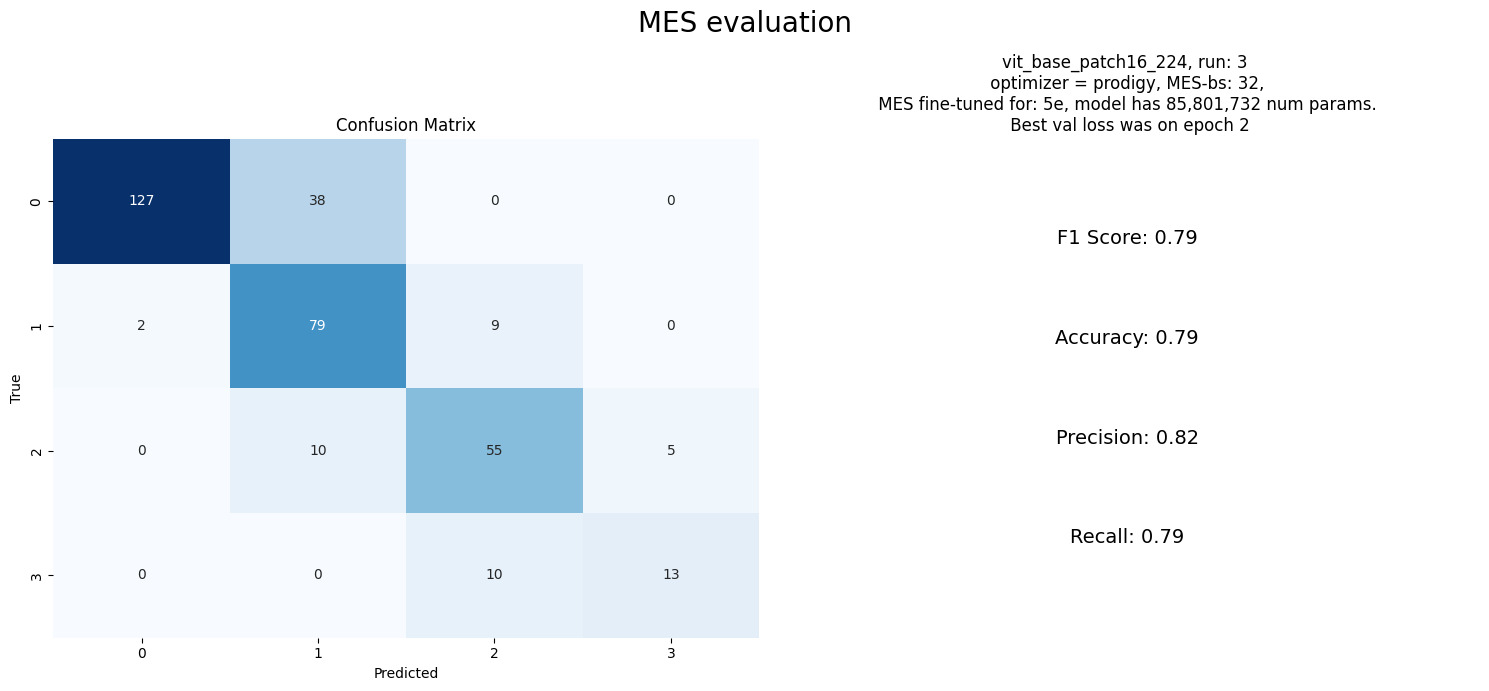

In [26]:
if three_shot:
    #load MAE 
    from sklearn.metrics import f1_score
    from IPython.display import clear_output
    mes_load_dir =  f'C:\\Users\\alx\\Downloads\\mdl_ckpt\mes_m-{mask_ratio}' #used for loading

    for i in range(3): #3 MES runs
        clear_output()
        print(f'### RUN {i}/3 ###')

        #run MES training:
        test_loader, test_data, now, best_epoch_was, best_f1_epoch_was, classifier = single_mes_run(i)

        # run eval on last model
        # specific_model_path = 'mes_last.pth'
        # specific_load_path = os.path.join(mes_load_dir, specific_model_path)
        model_used = 'last'
        eval_plot_name = f"MAE-370K_opt-{custom_opt}_max-e-{num_epochs}_MAE_mes-bs-{MAE_batch_size}_{mes_batch_size}_mask-{mask_ratio}_embdims-{emb_dims}_fine-e-{num_fine_epochs}_last_run{i+1}"
        f1, accuracy, precision, recall, cm = calculate_evaluation_metrics(classifier, test_data)
        mes_run_eval_plot(f1, accuracy, precision, recall, cm, i, model_used, best_epoch_was, eval_plot_name)

        # # run eval on best  val loss model
        # #load best.pth
        # specific_model_path = 'mes_best.pth'
        # specific_load_path = os.path.join(mes_load_dir, specific_model_path)
        # load_fine_tuned_model(path=specific_load_path)
        
        # model_used = 'best_val_loss'
        # eval_plot_name = f"MAE-370K_opt-{custom_opt}_max-e-{num_epochs}_MAE_mes-bs-{MAE_batch_size}_{mes_batch_size}_mask-{mask_ratio}_embdims-{emb_dims}_fine-e-{num_fine_epochs}_best-valloss_run{i+1}"
        # f1, accuracy, precision, recall, cm = calculate_evaluation_metrics(classifier, test_data)
        # mes_run_eval_plot(f1, accuracy, precision, recall, cm, i, model_used, best_epoch_was, eval_plot_name)


        # # run eval on best f1 score
        # #load best_f1.pth
        # specific_model_path = 'mes_best_f1.pth'
        # specific_load_path_f1 = os.path.join(mes_load_dir, specific_model_path)
        # load_fine_tuned_model(path=specific_load_path_f1)

        # model_used = 'best_val_f1'
        # eval_plot_name = f"MAE-370K_opt-{custom_opt}_max-e-{num_epochs}_MAE_mes-bs-{MAE_batch_size}_{mes_batch_size}_mask-{mask_ratio}_embdims-{emb_dims}_fine-e-{num_fine_epochs}_best-val-f1_run{i+1}"
        # f1, accuracy, precision, recall, cm = calculate_evaluation_metrics(classifier, test_data)
        # mes_run_eval_plot(f1, accuracy, precision, recall, cm, i, model_used, best_epoch_was, eval_plot_name)



In [27]:
end_time = time.time()
total_time = end_time - start_time
print(f"Total runtime of this run: {total_time//60//60} hrs")

Total runtime of this run: 0.0 hrs


In [28]:
if os.name == 'nt':
    import winsound

    # Play a sound
    winsound.PlaySound("SystemExit", winsound.SND_ALIAS)
    winsound.PlaySound("SystemExit", winsound.SND_ALIAS)
    winsound.PlaySound("SystemExit", winsound.SND_ALIAS)
    winsound.PlaySound("SystemExit", winsound.SND_ALIAS)
    winsound.PlaySound("SystemExit", winsound.SND_ALIAS)